In [2]:
import tensorflow as tf
import os
import pickle
import numpy as np
import time
import matplotlib.pyplot as plt

# Plot configurations
%matplotlib inline



In [3]:
import pickle
import os
import tarfile
import urllib.request as url
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        res = pickle.load(fo, encoding='bytes')
    return res
        
def load_data():
    os.chdir('./')
    meta = unpickle('./data/cifar-100-python/meta')
    coarse_label_names = [t.decode('utf8') for t in meta[b'coarse_label_names']]

    train = unpickle('./data/cifar-100-python//train')
    y_train = np.array(train[b'coarse_labels'])
    X_train = np.array(train[b'data'])

    test = unpickle('./data/cifar-100-python//test')
    y_test = np.array(test[b'coarse_labels'])
    X_test = np.array(test[b'data'])
    
    return coarse_label_names, X_train, y_train, X_test, y_test




#### Task 1 : Assuming you are not familiar with the framework, in this part of the homework you will present your research describing the resources you used to learn the framework (must include links to all resources). Clearly explain why you needed a particular resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of all the computations in a NN i.e., what libraries/tools do you need within this framework.)

https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
https://ljvmiranda921.github.io/notebook/2017/02/17/artificial-neural-networks/

They are just random resources only which guide you how to implement two layer NN(forward/backward propagation, gradient update, etc)

#### Task 2 : Once you have figured the resources you need for the project, design, and implement your project. The project must include the following steps (it’s not limited to these steps):
1. Exploratory Data Analysis (Can include data cleaning, visualization etc.)
2. Perform a train-dev-test split.


['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
(50000, 32, 32, 3)
(49000, 3072) (1000, 3072) (1000, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


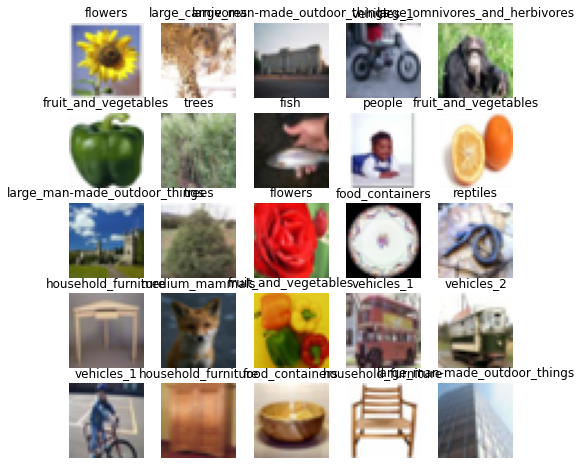

In [4]:
# Load the raw CIFAR-100 data. 
label_map, X_train, y_train, X_test, y_test = load_data()

# I flattened 1×32×32×3 images into 1×3072 Numpy arrays. Number 3 stands for 3 color channels.
# reshape vectorized data into the image format
X = X_train.reshape(50000, 3, 32, 32).transpose(0,2,3,1)

print(label_map)
print(X.shape)

#Visualizing CIFAR 100 data. Randomly choose 25 images from the train dataset to show.
fig, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])
        axes1[j][k].set_title(label_map[y_train[i]])
        
#    Train data: 49,000 samples from the original train set: indices 1~49,000
#    Validation data: 1,000 samples from the original train set: indices 49,000~50,000
#    Test data: 1,000 samples from the original test set: indices 1~1,000
num_training = 49000
num_validation = 1000
num_test = 1000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]


X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

X_test = X_test[:num_test, :]
y_test = y_test[:num_test]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


3. Implement forward propagation (clearly describe the activation functions and other
hyper-parameters you are using).
4. Compute the final cost function.


In [10]:
def forward_prop(x, w, b):
    return x.reshape(x.shape[0],-1) @ w + b

def backward_prop(dout, x, w, b):
    dx = (dout @ w.T).reshape(x.shape)
    dw = x.reshape(x.shape[0], -1).T @ dout
    db = np.sum(dout, axis=0)
    return dx, dw, db

def relu_forward(x):
    out = x.copy()
    out[out<0]=0
    return out

def relu_backward(dout, x):
    dx = dout*(x>0)
    return dx

def softmax(z):
    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] 
    return e_x / div
    #ref: https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
    
def softmax_loss(x, y):
    
    # When calculating the cross entropy,
    # you may meet another problem about numerical stability, log(0)
    # to avoid this, I add a small number to it, log(0+epsilon)
    epsilon = 1e-15
    
    N = x.shape[0]
    S = softmax(x)
    # compute loss from fomula
    loss = 1/N * -np.sum(np.log(S[np.arange(N),y]))
    
    S_copy = S.copy()
    S_copy[np.arange(N),y] -= 1
    # compute dx from fomla
    dx = 1/N * S_copy

    return loss, dx

class DenseLayer:
    """
    I use ReLU as default activation function.
    """
    def __init__(self, input_dim, output_dim=100, weight_scale=1e-2):

        self.input_dim = input_dim
        self.output_dim = output_dim
        
        W = weight_scale*np.random.rand(input_dim, output_dim)
        b = np.zeros(output_dim)
        self.params = [W, b]
    
    def feedforward(self, X): #out = ReLU(X*W + b).
 
        W, b = self.params
        A = forward_prop(X, W, b)
        out = relu_forward(A)
        
        # create cache for backward
        self.X = X
        self.A = A
        
        return out
    
    def backward(self, dout):
        W, b = self.params
        X = self.X  # cache input data
        A = self.A  # cache intermediate affine result
        
        dX = np.zeros_like(X)
        dW = np.zeros_like(W)
        db = np.zeros_like(b)
        Relu_output = relu_backward(dout, A)
        dX, dW, db = backward_prop(Relu_output, X, W, b)

        self.gradients = [dW, db]
        return dX
    
    def update_layer(self, params):
        
        self.params = params

        
class AffineLayer:
   
    def __init__(self, input_dim, output_dim=100, weight_scale=1e-2):
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        W = weight_scale*np.random.rand(input_dim, output_dim)
        b = np.zeros(output_dim)
        self.params = [W, b]
    
    def feedforward(self, X):
        W, b = self.params
        out = forward_prop(X, W, b)
        self.X = X
        return out
    
    def backward(self, dout):
        
        W, b = self.params
        X = self.X
        
        dX = np.zeros_like(X)
        dW = np.zeros_like(W)
        db = np.zeros_like(b)
        
        dX, dW, db = backward_prop(dout, X, W, b)
        self.gradients = [dW, db]
        
        return dX
    
    def update_layer(self, params):
        
        self.params = params
    
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. 
    """

    def __init__(self, input_dim=3072, hidden_dim=200, num_classes=10, reg=0.0, weight_scale=1e-3):
        
        self.layer1 = DenseLayer(input_dim, hidden_dim, weight_scale=weight_scale)
        self.layer2 = AffineLayer(hidden_dim, num_classes, weight_scale=weight_scale)
        self.reg = reg
        self.velocities = None

    def loss(self, X, y):
        loss = 0.0
        reg = self.reg
        out = self.layer2.feedforward(self.layer1.feedforward(X))
        
        loss, dx = softmax_loss(out, y)
        dx = self.layer1.backward(self.layer2.backward(dx))

        # Add L2 regularization
        square_weights = np.sum(self.layer1.params[0]**2) + np.sum(self.layer2.params[0]**2)
        loss += 0.5*self.reg*square_weights
        return loss

    def step(self, learning_rate=1e-5, optim='SGD', momentum=0.5):
        
        # creates new lists with all parameters and gradients
        layer1, layer2 = self.layer1, self.layer2
        params = layer1.params + layer2.params
        grads = layer1.gradients + layer2.gradients
        
        if self.velocities is None:
            self.velocities = [np.zeros_like(param) for param in params]
        
        # Add L2 regularization
        reg = self.reg
        grads = [grad + reg*params[i] for i, grad in enumerate(grads)]


        for i, _ in enumerate(params):
            self.velocities[i] = momentum * self.velocities[i] + learning_rate * grads[i]
            params[i] = params[i] - self.velocities[i]
   
        # update parameters in layers
        layer1.update_layer(params[0:2])
        layer2.update_layer(params[2:4])
        self.layer1 = layer1
        self.layer2 = layer2


    def predict(self, X):

        predictions = None
        layer1, layer2 = self.layer1, self.layer2
        S = softmax(self.layer2.feedforward(self.layer1.feedforward(X)))
        predictions = np.argmax(S,axis = 1)

        return predictions
    
    def check_accuracy(self, X, y):

        y_pred = self.predict(X)
        acc = np.mean(np.equal(y, y_pred))
        
        return acc
    


5. Implement mini-batch gradient descent to train your model. In this step it is up to you
as someone in charge of their project to improvise using optimization algorithms
(Adams, RMSProp etc.) and/or regularization.

In [18]:
def train(model,  X_train, y_train, X_valid, y_valid, 
          num_epoch=20, batch_size=400, learning_rate=5e-4, learning_decay=0.95, optim='SGD', momentum=None, verbose=False):
    num_train = X_train.shape[0]
    num_batch = num_train//batch_size
    print('number of batches for training: {}'.format(num_batch))
    train_acc_hist = []
    val_acc_hist = []
    for e in range(num_epoch):
        # Train stage
        for i in range(num_batch):
            ## Ordered selection
            #X_batch = X_train[i*batch_size:(i+1)*batch_size]
            #y_batch = y_train[i*batch_size:(i+1)*batch_size]
            ## Random selection
            sample_idxs = np.random.choice(num_train, batch_size)
            X_batch = X_train[sample_idxs,:]
            y_batch = y_train[sample_idxs]
            ## loss
            loss = model.loss(X_batch, y_batch)
            # update model
            if optim == 'SGD':
                model.step(learning_rate=learning_rate)
            else:
                model.step(learning_rate=learning_rate, optim=optim, momentum=momentum)
            
            if verbose and (i+1)%10==0:
                print('{}/{} loss: {}'.format(batch_size*(i+1), num_train, loss))
            
        # Validation stage
        sample_idxs = np.random.choice(num_train, 1000)
        train_acc = model.check_accuracy(X_train[sample_idxs,:], y_train[sample_idxs])
        train_acc_hist.append(train_acc)
        
        val_acc = model.check_accuracy(X_valid, y_valid)
        val_acc_hist.append(val_acc)
        # Shrink learning_rate
        learning_rate *= learning_decay
        print('epoch {}: train acc = {}, val acc = {}'.format(e+1, train_acc, val_acc))
        
    # Return Loss history
    return train_acc_hist, val_acc_hist
        
## Test 
def test(model, X_test, y_test):
    test_acc = model.check_accuracy(X_test, y_test)
    print('test acc: {}'.format(test_acc))
    return test_acc


6. Present the results using the test set.

In [17]:
## Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=400, num_classes=20, reg=1e-4, weight_scale=1e-3)
num_epoch = 50
batch_size = 512
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 95


/var/folders/5z/5q60dfjs0rlck3kfdyn4_t700000gn/T/ipykernel_15720/1827706420.py:38: RuntimeWarning: divide by zero encountered in log
  loss = 1/N * -np.sum(np.log(S[np.arange(N),y]))


epoch 1: train acc = 0.136, val acc = 0.119
epoch 2: train acc = 0.221, val acc = 0.223
epoch 3: train acc = 0.258, val acc = 0.212
epoch 4: train acc = 0.298, val acc = 0.274
epoch 5: train acc = 0.333, val acc = 0.276
epoch 6: train acc = 0.304, val acc = 0.296
epoch 7: train acc = 0.342, val acc = 0.304
epoch 8: train acc = 0.377, val acc = 0.307
epoch 9: train acc = 0.399, val acc = 0.325
epoch 10: train acc = 0.412, val acc = 0.337
epoch 11: train acc = 0.414, val acc = 0.319
epoch 12: train acc = 0.424, val acc = 0.346
epoch 13: train acc = 0.404, val acc = 0.34
epoch 14: train acc = 0.44, val acc = 0.341
epoch 15: train acc = 0.433, val acc = 0.343
epoch 16: train acc = 0.433, val acc = 0.341
epoch 17: train acc = 0.46, val acc = 0.351
epoch 18: train acc = 0.457, val acc = 0.349
epoch 19: train acc = 0.471, val acc = 0.358
epoch 20: train acc = 0.458, val acc = 0.344
epoch 21: train acc = 0.494, val acc = 0.354
epoch 22: train acc = 0.497, val acc = 0.371
epoch 23: train acc = 

0.367

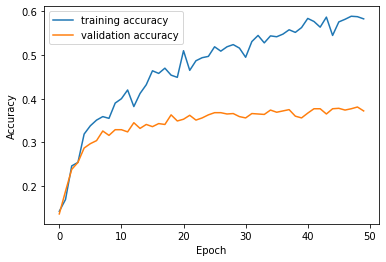

In [15]:
import matplotlib.pyplot as plt
plt.plot(train_acc_hist, label='training accuracy')
plt.plot(val_acc_hist, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



#### Task 3 (15 points): In task 2 describe how you selected the hyperparameters. What was the rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use an optimization algorithm? Why or why not?

Here are some common recommended methods for improving the performance. 

1. Hyperparameter tuning: regression param, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 

By gradually lower the learning rate, increasing the hidden_dim size for a more complexing network, increasing the num_epoch, then I obtain a better accuracy. The accuracy of my best model is 0.367. (input_dim=3072, hidden_dim=400, num_classes=20, reg=1e-4, weight_scale=1e-3). Regularization is needed because adding the regularization component will drive the values of the weight matrix down. This will effectively decorrelate the neural network. By reducing the values in the weight matrix, the output will also be reduced, which in turns decreases the effect of the activation function. Therefore, a less complex function will be fit to the data, effectively reducing overfitting. For optimization I am using SGD here( I also tried SGD with momentum but it doens't really improve the convergence speed a lot).